In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
book_movie = pd.read_csv('book_movie_database.csv')

In [170]:
book_movie.describe().round(2)

,book_rating,book_number_ratings,book_year_published,popularity,movie_runtime,movie_rating,movie_number_ratings
count,692.00,692.00,692.00,692.00,692.00,692.00,692.00
mean,3.92,338229.38,1938.19,7.98,112.61,6.44,595.48
std,0.22,565192.76,96.27,8.28,32.19,0.90,1162.89
min,3.08,209.00,1536.00,0.03,25.00,2.00,1.00
25%,3.80,34436.00,1920.25,2.48,95.00,5.90,20.00
50%,3.94,151602.00,1975.50,6.85,107.50,6.50,131.50
75%,4.07,403176.50,1998.00,10.76,125.00,7.00,635.75
max,4.56,5680570.00,2018.00,88.44,386.00,10.00,9678.00


In [171]:
#Let's examine the initial relationship between our variables
book_movie.corr()

,book_rating,book_number_ratings,book_year_published,popularity,movie_runtime,movie_rating,movie_number_ratings
book_rating,1.000000,0.237532,0.024509,0.082068,0.001495,0.255455,0.200784
book_number_ratings,0.237532,1.000000,-0.063233,0.183304,0.119640,0.111955,0.341852
book_year_published,0.024509,-0.063233,1.000000,0.249751,-0.099355,0.028683,0.212469
popularity,0.082068,0.183304,0.249751,1.000000,0.093390,0.258327,0.685483
movie_runtime,0.001495,0.119640,-0.099355,0.093390,1.000000,0.156575,0.126660
movie_rating,0.255455,0.111955,0.028683,0.258327,0.156575,1.000000,0.310184
movie_number_ratings,0.200784,0.341852,0.212469,0.685483,0.126660,0.310184,1.000000


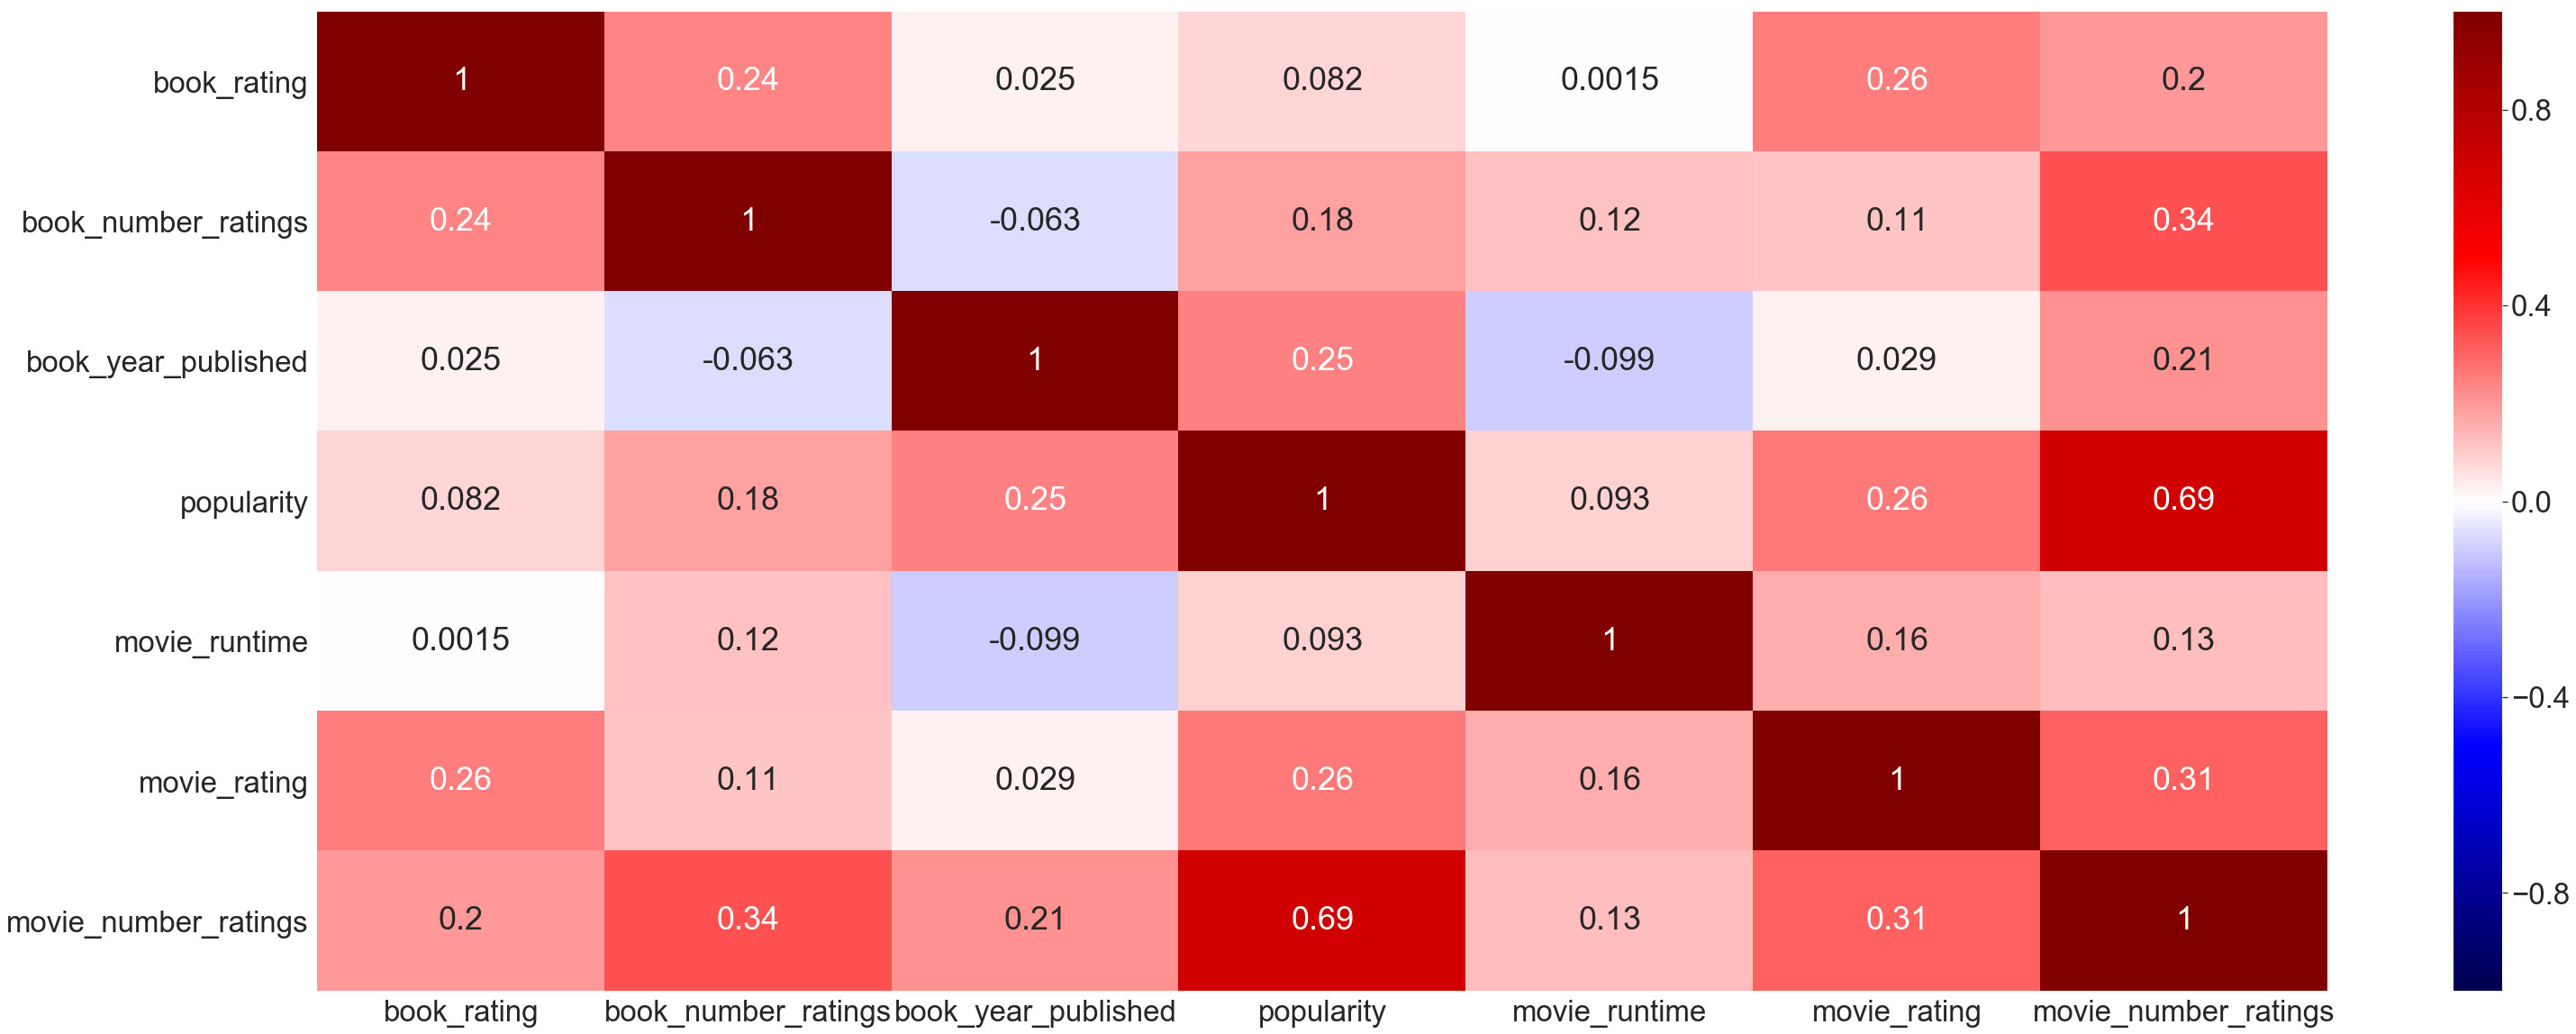

In [172]:
sns.set(font_scale=3) 
plt.figure(figsize=(50,20))
sns.heatmap(book_movie.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

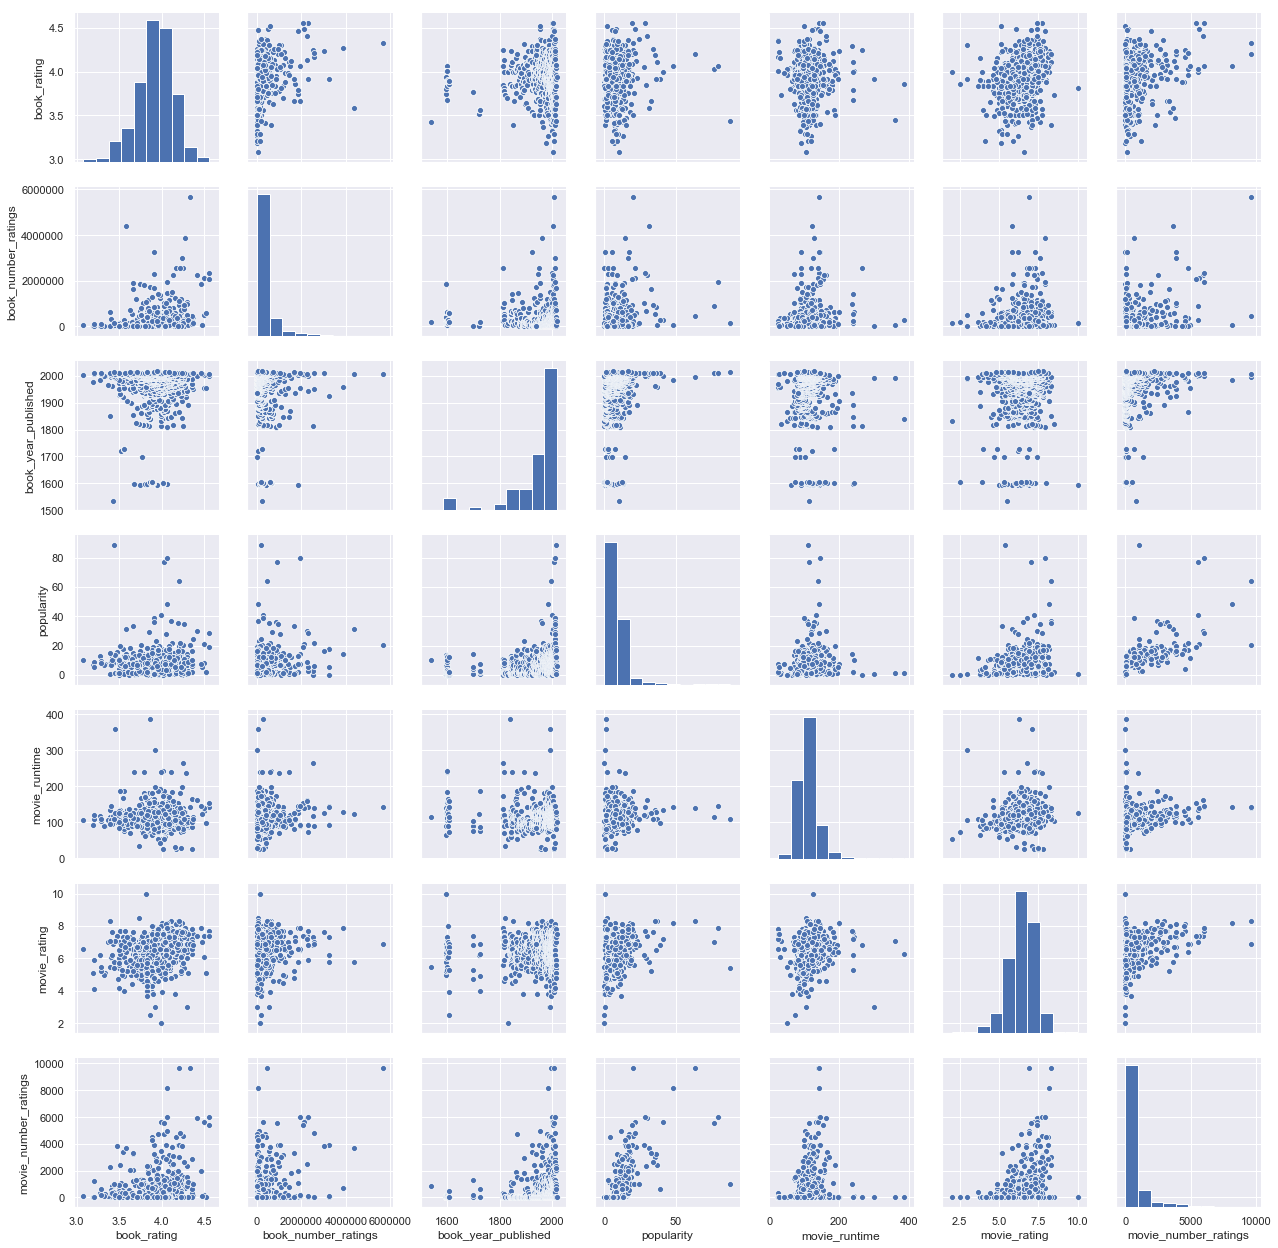

In [173]:
#Examine the histrograms:
sns.set(font_scale=1) 
sns.pairplot(book_movie);

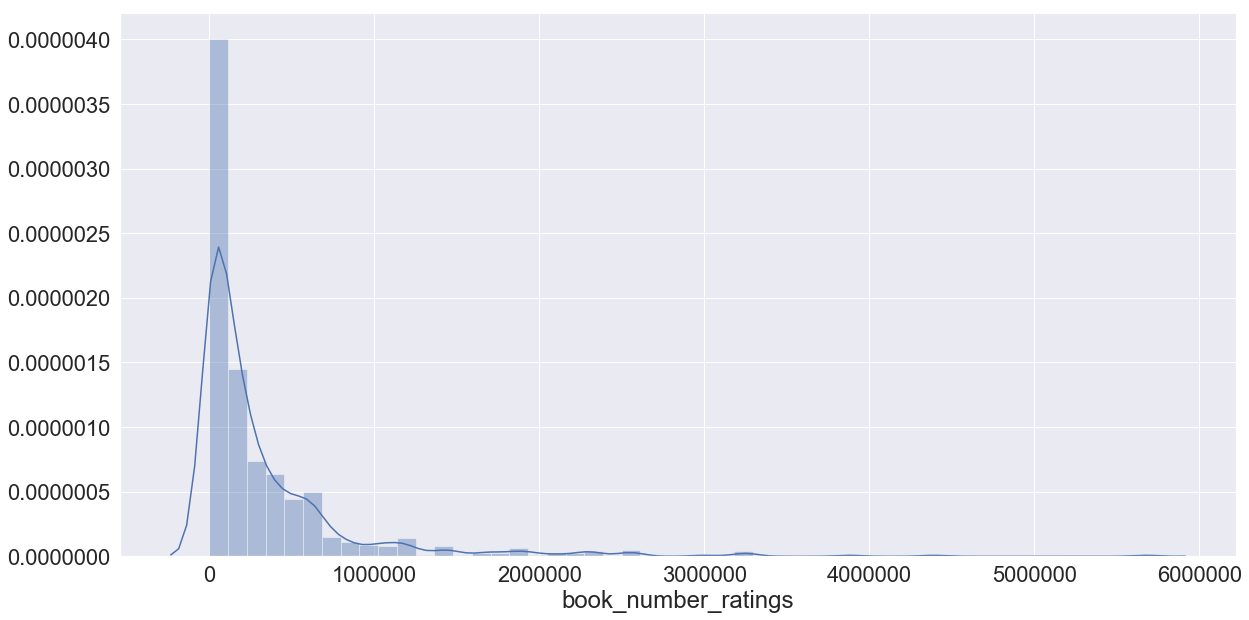

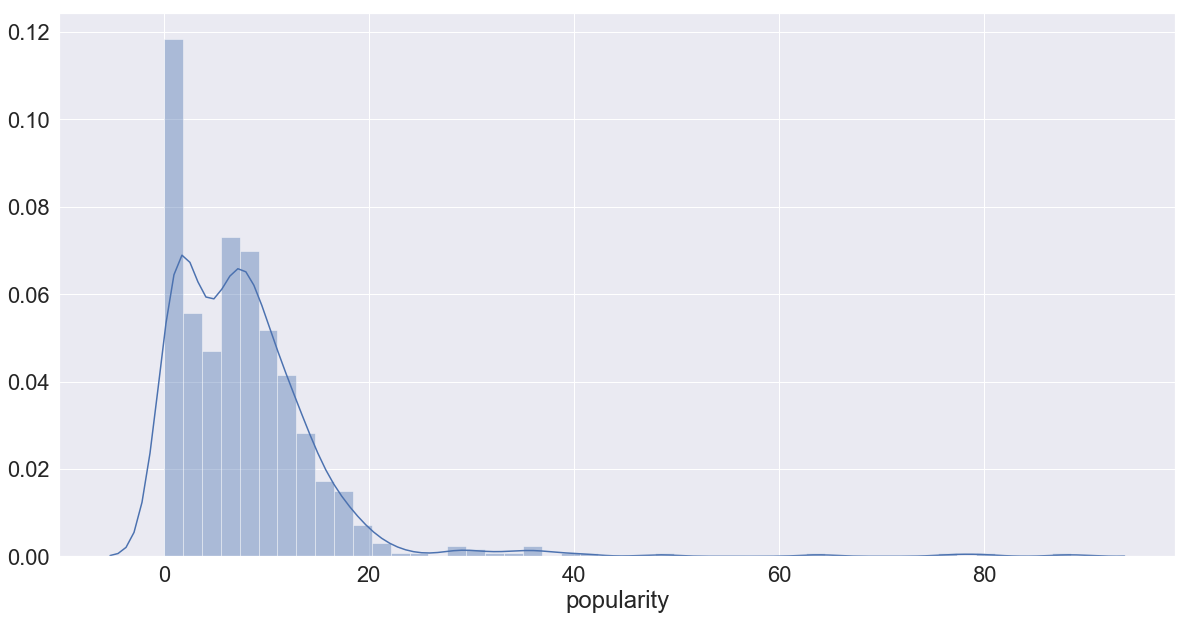

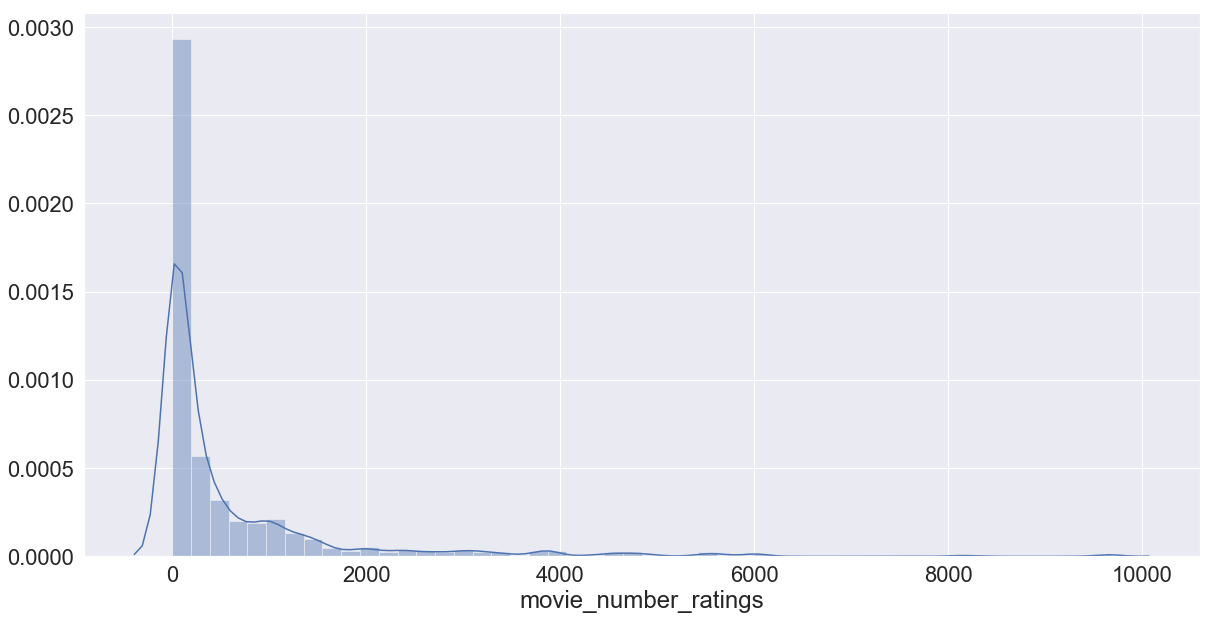

In [174]:
#These features appear heavily skewed:
#book_number_ratings
#movie_number_ratings
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.distplot(book_movie['book_number_ratings'])

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.distplot(book_movie['popularity'])

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.distplot(book_movie['movie_number_ratings'])

#They are good candidates for a log transformation

In [175]:
#Applying the log transformation to those features:

book_movie['popularity_log'] = np.log(book_movie['popularity'])
book_movie['book_number_ratings_log'] = np.log(book_movie['book_number_ratings'])
book_movie['movie_number_ratings_log'] = np.log(book_movie['movie_number_ratings'])

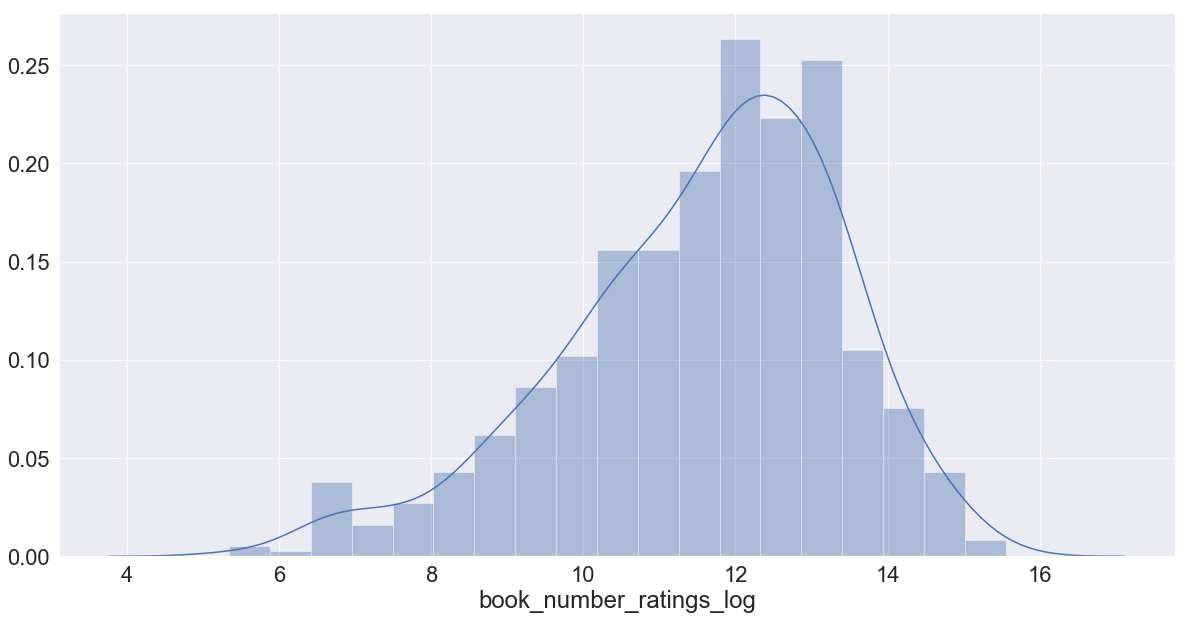

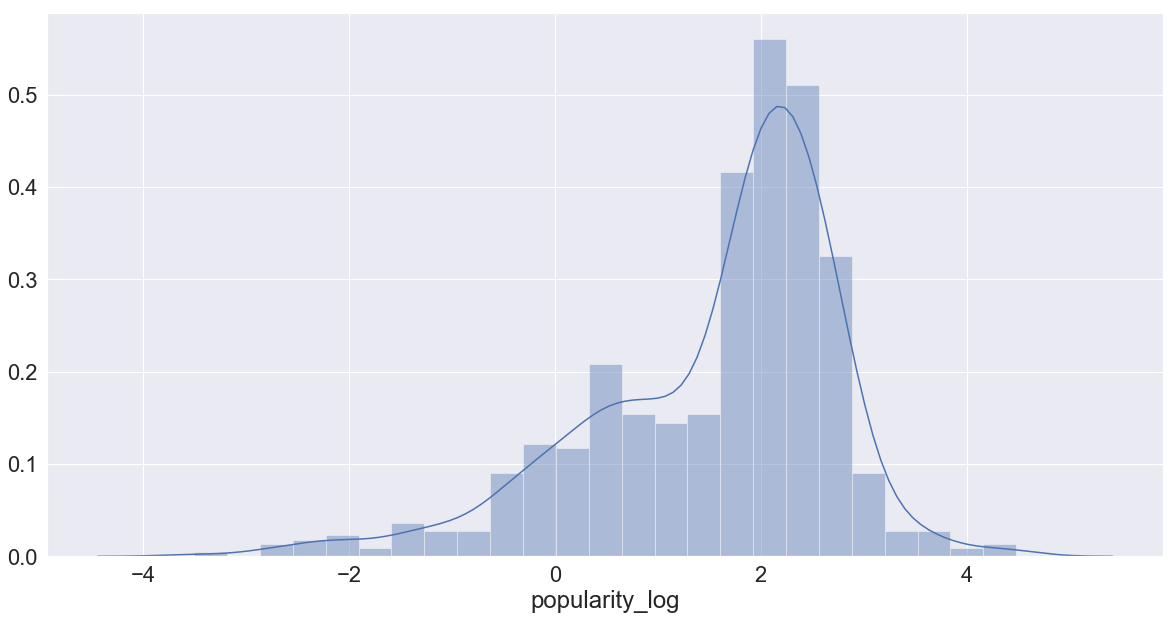

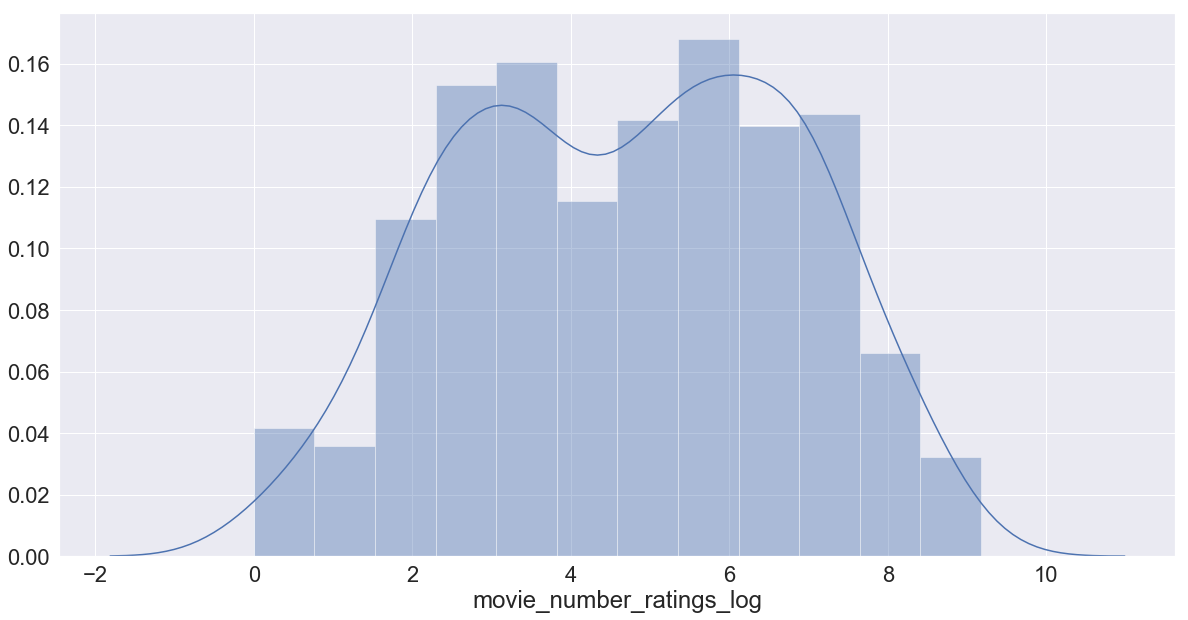

In [176]:
#Now let's plot them again to see the difference:

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.distplot(book_movie['book_number_ratings_log'])

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.distplot(book_movie['popularity_log'])

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.distplot(book_movie['movie_number_ratings_log'])

#The results are not perfect but they are closer to a normal distribution than before.

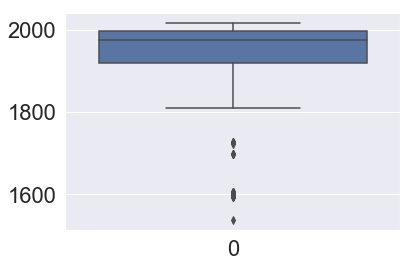

In [177]:
#Looking at the year the book was published, there are a few noticeable outliers:

sns.boxplot(data = book_movie['book_year_published'])

In [178]:
date_list = np.array(book_movie['book_year_published'])
q25,q50,q75 = np.percentile(date_list, [25,50,75])
iqr = q75 - q25
minimum = q25 - 1.5*(iqr)
maximum = q75 + 1.5*(iqr)
print(minimum.round(2), q25, q50, q75, maximum.round(2))
print([x for x in book_movie['book_year_published'] if x > maximum])
print([x for x in book_movie['book_year_published'] if x < minimum])

1803.62 1920.25 1975.5 1998.0 2114.62
[]
[1536, 1593, 1593, 1593, 1595, 1595, 1595, 1595, 1595, 1596, 1598, 1598, 1599, 1599, 1599, 1600, 1600, 1600, 1600, 1600, 1600, 1603, 1603, 1603, 1603, 1603, 1603, 1605, 1605, 1606, 1606, 1606, 1606, 1697, 1697, 1697, 1697, 1722, 1726, 1726, 1726, 1726]


In [179]:
#There are a few years where a book was published quite early, before movies even existed, so there are noticeable outliers.
#Let's set these outliers to the max values in the dataset to remove those early values:

book_movie.loc[book_movie.book_year_published < minimum, 'book_year_published'] = np.nan
book_movie.fillna(minimum, inplace = True)

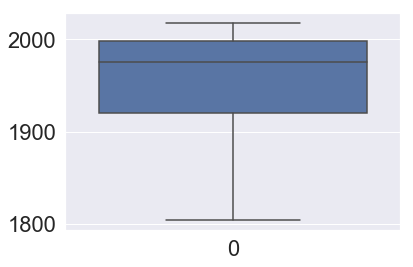

In [180]:
sns.boxplot(data = book_movie['book_year_published'])

In [181]:
book_movie['book_year_publish_or'] = book_movie['book_year_published']

In [182]:
book_movie = book_movie.drop(columns = ['popularity', 'book_number_ratings', 'movie_number_ratings', 'book_year_published'])

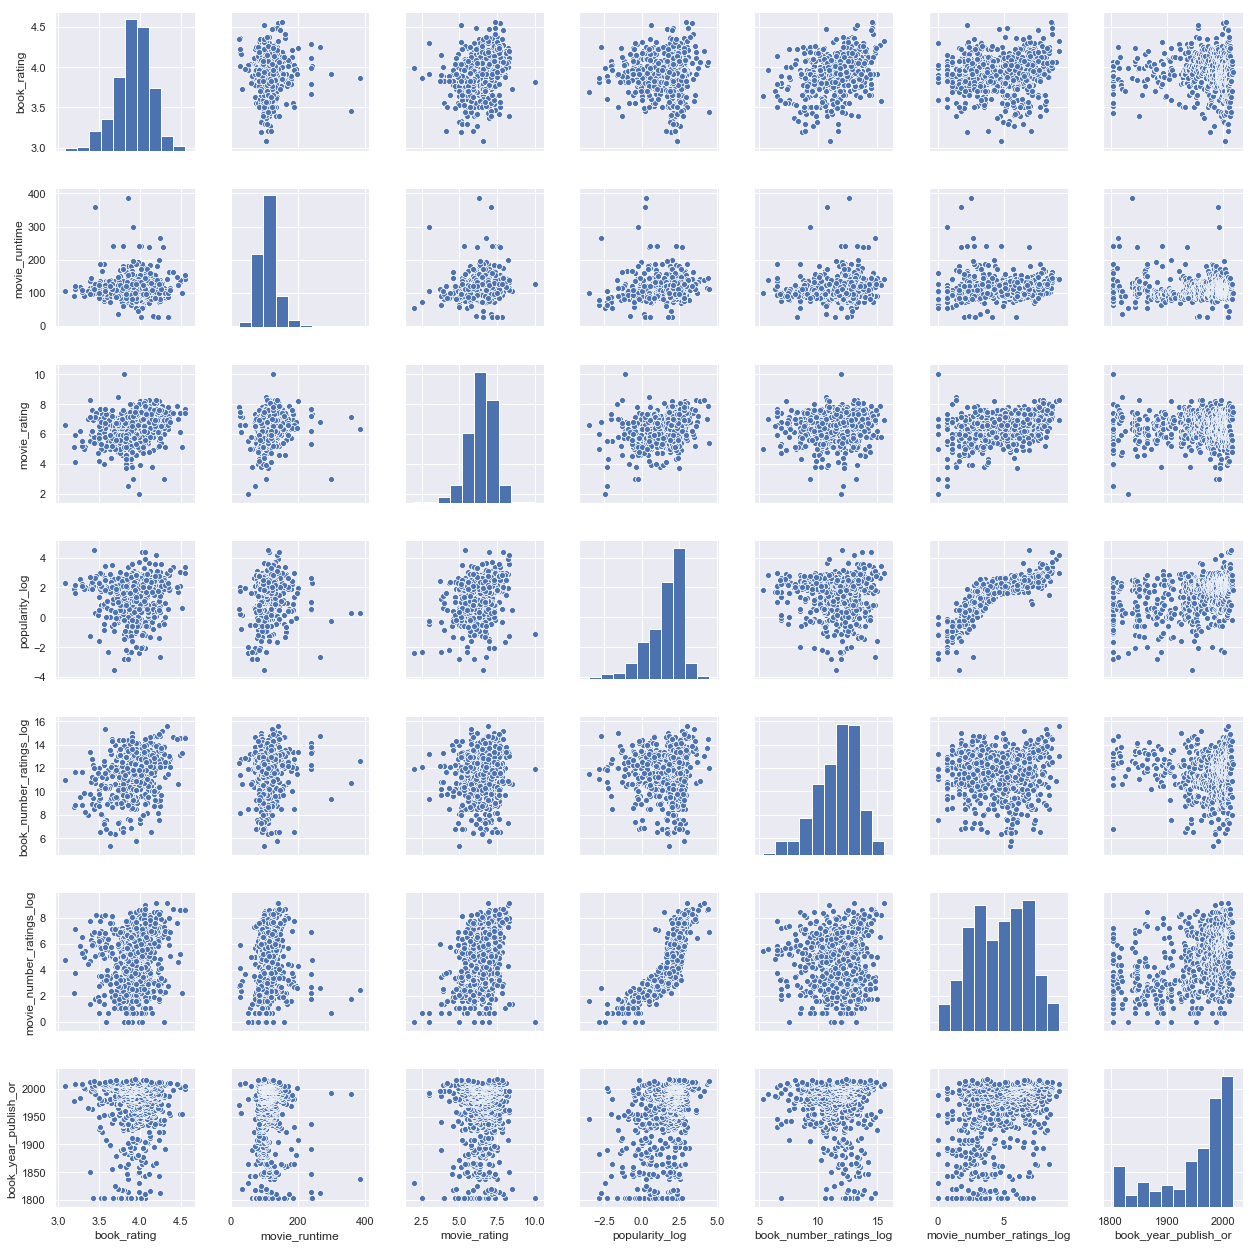

In [183]:
#Now that the features have been transformed, let's examine the pairplot again:
sns.set(font_scale=1) 
sns.pairplot(book_movie)

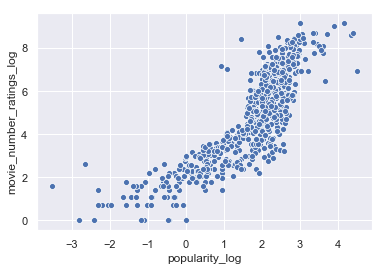

In [186]:
#It looks like the popularity_log and movie_number_ratings_log are candidates for a polynomial tranformation

sns.scatterplot(x = book_movie['popularity_log'], y = book_movie['movie_number_ratings_log'])

In [187]:
book_movie['popularity_log'] = book_movie['popularity_log']**2

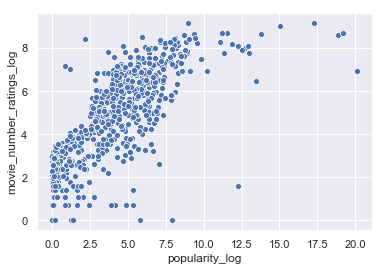

In [188]:
sns.scatterplot(x = book_movie['popularity_log'], y = book_movie['movie_number_ratings_log'])